In [1]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('mode.chained_assignment', None)

In [2]:
df_l = pd.read_csv('data/listings.csv', low_memory = False)

In [3]:
df_l.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,gmaps_result,centre_transit_time
0,23163,https://www.airbnb.com/rooms/23163,20200229181007,2020-03-01,"Quiet 1BR directly in the Centre, Air-conditio...","Unique and elegant apartment rental in Prague,...",Unique and elegant apartment rental in Prague ...,"Unique and elegant apartment rental in Prague,...",none,Check my guidebook for this apartment to disco...,"To help you with your first steps in Prague, I...",The closest METRO station is called „Narodni t...,NaN,"Of course, you can contact me anytime during y...",Thank you for treating the property like it wa...,NaN,NaN,https://a0.muscache.com/im/pictures/01bbe32c-3...,NaN,5282,https://www.airbnb.com/users/show/5282,Klara,2008-12-17,"Prague, Prague, Czech Republic","Hello, \r\nglad to see that you are interested...",within an hour,97%,100%,t,https://a0.muscache.com/im/pictures/user/b7309...,https://a0.muscache.com/im/pictures/user/b7309...,Josefov,69.0,69.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Prague, Czech Republic, Czech Republic",Staré Město,Praha 1,NaN,Prague,Czech Republic,11000,Prague,"Prague, Czech Republic",CZ,Czech Republic,50.08229,14.41552,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",775.0,"$3,717.00",NaN,NaN,"$2,546.00",NaN,2,$636.00,1,365,1,7,365,365,5.6,365.0,today,t,19,40,70,288,2020-03-01,19,3,2010-09-20,2019-07-27,98.0,9.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,t,f,moderate,f,f,69,68,0,0,0.17,{'destination_addresses': ['Staroměstské nám. ...,9.883333
1,23169,https://www.airbnb.com/rooms/23169,20200229181007,2020-03-01,M302-Cozy Serviced Studio in Center,Masna studio offers a lot of space and privacy...,* CENTRAL LOCATION * EQUIPPED KITCHEN * BALCON...,Masna studio offers a lot of space and privacy...,none,Check my guidebook for this apartment to disco...,"To help you with your first steps in Prague, I...",The closest METRO station is called „Staromest...,NaN,"Of course, you can contact me anytime during y...",Thank you for treating the property like it wa...,NaN,NaN,https://a0.muscache.com/im/pictures/35353e66-2...,NaN,5282,https://www.airbnb.com/users/show/5282,Klara,2008-12-17,"Prague, Prague, Czech Republic","Hello, \r\nglad to see that you are interested...",within an hour,97

In [4]:
cols_to_keep = ['host_since', 'host_response_time', 'host_is_superhost', 'neighbourhood_cleansed', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'number_of_reviews', 'review_scores_rating', 'cancellation_policy', 'centre_transit_time']

In [5]:
df_lf = df_l[cols_to_keep]

In [6]:
features = df_lf.isnull().sum() / df_lf.shape[0]
features[features < 0.8].sort_values(ascending = False)

security_deposit          0.280220
cleaning_fee              0.194849
host_response_time        0.187157
review_scores_rating      0.137157
beds                      0.008173
bedrooms                  0.001442
bathrooms                 0.000481
host_is_superhost         0.000069
host_since                0.000069
cancellation_policy       0.000000
price                     0.000000
guests_included           0.000000
accommodates              0.000000
room_type                 0.000000
neighbourhood_cleansed    0.000000
extra_people              0.000000
number_of_reviews         0.000000
centre_transit_time       0.000000
dtype: float64

In [7]:
df_lf[['price', 'security_deposit', 'cleaning_fee', 'extra_people']].head()

,price,security_deposit,cleaning_fee,extra_people
0,"$3,717.00","$2,546.00",NaN,$636.00
1,"$2,493.00","$2,546.00",NaN,$636.00
2,"$2,540.00","$5,092.00",$458.00,$255.00
3,"$2,032.00","$3,819.00",$458.00,$204.00
4,"$1,039.00",$0.00,$350.00,$0.00


In [8]:
def convert_prices(df, cols):
    for col in cols:
        df[col] = df[col].str.replace('[$|,]', '').astype(float)
    return df

In [9]:
df_lf = convert_prices(df_lf, ['price', 'security_deposit', 'cleaning_fee', 'extra_people'])

In [10]:
df_lf[['price', 'security_deposit', 'cleaning_fee', 'extra_people']].head()

,price,security_deposit,cleaning_fee,extra_people
0,3717.0,2546.0,NaN,636.0
1,2493.0,2546.0,NaN,636.0
2,2540.0,5092.0,458.0,255.0
3,2032.0,3819.0,458.0,204.0
4,1039.0,0.0,350.0,0.0


In [11]:
for col in df_lf.dtypes[df_lf.dtypes == 'float'].index.tolist():
    df_lf[col] = df_lf[col].fillna(df_lf[col].mean())

In [12]:
df_lf[['price', 'security_deposit', 'cleaning_fee', 'extra_people']].head()

,price,security_deposit,cleaning_fee,extra_people
0,3717.0,2546.0,508.480508,636.0
1,2493.0,2546.0,508.480508,636.0
2,2540.0,5092.0,458.000000,255.0
3,2032.0,3819.0,458.000000,204.0
4,1039.0,0.0,350.000000,0.0


## Converting date in host_since to a relative days to present day

In [13]:
df_lf['host_since'] = df_lf['host_since'].apply(lambda x: (pd.to_datetime('2020-03-01') - pd.to_datetime(x)).days)

## We can encode the categorical column containing the information about superhsot to a boolean series

In [14]:
df_lf['host_is_superhost'] = df_lf['host_is_superhost'].replace({'t': 1, 'f': 0})

# Preparing categorical variables

In [15]:
df_lf.head()

,host_since,host_response_time,host_is_superhost,neighbourhood_cleansed,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,number_of_reviews,review_scores_rating,cancellation_policy,centre_transit_time
0,4092.0,within an hour,1.0,Praha 1,Entire home/apt,4,1.0,1.0,2.0,3717.0,2546.0,508.480508,2,636.0,19,98.0,moderate,9.883333
1,4092.0,within an hour,1.0,Praha 1,Entire home/apt,4,1.0,1.0,2.0,2493.0,2546.0,508.480508,2,636.0,113,95.0,moderate,4.766667
2,3597.0,within an hour,1.0,Praha 7,Entire home/apt,6,1.0,2.0,2.0,2540.0,5092.0,458.000000,4,255.0,345,97.0,moderate,16.900000
3,3597.0,within an hour,1.0,Praha 1,Entire home/apt,4,1.5,1.0,2.0,2032.0,3819.0,458.000000,3,204.0,246,99.0,moderate,13.450000
4,3585.0,within an hour,1.0,Praha 3,Entire home/apt,2,1.0,0.0,1.0,1039.0,0.0,350.000000,1,0.0,411,96.0,moderate,20.683333


In [16]:
cat_cols= df_lf.dtypes[df_lf.dtypes == 'object'].index.tolist()
cat_cols

['host_response_time',
 'neighbourhood_cleansed',
 'room_type',
 'cancellation_policy']

In [17]:
def group_cat(df, col, new_value_name = 'Other', threshold = 0.01):
    new_col = col + '_new'
    df_g = df.groupby(col)[df.columns[0]].count().reset_index()
    df_g['ratio'] = df_g[df.columns[0]] / df_lf.shape[0]
    df_g[new_col] = df_g.apply(lambda x: x[col] if (x['ratio'] > threshold) else new_value_name, axis = 1)
    print(df_g.groupby(new_col)['ratio'].sum())
    
    s = df.merge(df_g[[col, new_col]], on = col)[new_col]
    ohe = pd.get_dummies(s, prefix = col)
    return df.merge(ohe, left_index = True, right_index = True).drop(col, axis = 1)

In [18]:
for col in cat_cols:    
    df_lf = group_cat(df_lf, col, threshold = 0.05)

host_response_time_new
Other                 0.011882
within a day          0.050618
within a few hours    0.069712
within an hour        0.680632
Name: ratio, dtype: float64
neighbourhood_cleansed_new
Other       0.153866
Praha 1     0.291762
Praha 10    0.053485
Praha 2     0.159527
Praha 3     0.136967
Praha 5     0.088044
Praha 7     0.056612
Praha 8     0.059654
Name: ratio, dtype: float64
room_type_new
Entire home/apt    0.782425
Other              0.048331
Private room       0.169159
Name: ratio, dtype: float64
cancellation_policy_new
Other                          0.011829
flexible                       0.247486
moderate                       0.360287
strict_14_with_grace_period    0.380313
Name: ratio, dtype: float64


In [19]:
df_lf.head()

,host_since,host_is_superhost,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,number_of_reviews,review_scores_rating,centre_transit_time,host_response_time_Other,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_cleansed_Other,neighbourhood_cleansed_Praha 1,neighbourhood_cleansed_Praha 10,neighbourhood_cleansed_Praha 2,neighbourhood_cleansed_Praha 3,neighbourhood_cleansed_Praha 5,neighbourhood_cleansed_Praha 7,neighbourhood_cleansed_Praha 8,room_type_Entire home/apt,room_type_Other,room_type_Private room,cancellation_policy_Other,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period
0,4092.0,1.0,4,1.0,1.0,2.0,3717.0,2546.0,508.480508,2,636.0,19,98.0,9.883333,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,4092.0,1.0,4,1.0,1.0,2.0,2493.0,2546.0,508.480508,2,636.0,113,95.0,4.766667,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3597.0,1.0,6,1.0,2.0,2.0,2540.0,5092.0,458.000000,4,255.0,345,97.0,16.900000,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
3,3597.0,1.0,4,1.5,1.0,2.0,2032.0,3819.0,458.000000,3,204.0,246,99.0,13.450000,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
4,3585.0,1.0,2,1.0,0.0,1.0,1039.0,0.0,350.000000,1,0.0,411,96.0,20.683333,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


In [20]:
df_lf.isnull().sum().sum()

2

In [21]:
df_lf = df_lf.dropna()

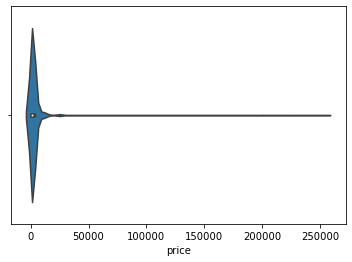

In [22]:
sns.violinplot(df_lf['price'])

In [23]:
df_lf['price'].quantile(.9)

4109.0

In [24]:
df_lf = df_lf[df_lf['price'] < df_lf['price'].quantile(.9)]

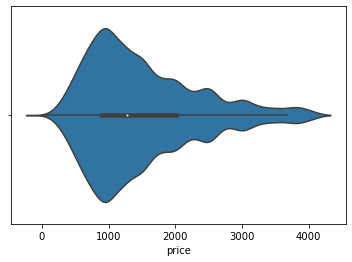

In [25]:
sns.violinplot(df_lf['price'])

In [26]:
corr_matrix = df_lf.corr()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

In [27]:
sol[:20]

neighbourhood_cleansed_Praha 1         cancellation_policy_moderate                       0.859180
host_response_time_within an hour      room_type_Entire home/apt                          0.834048
room_type_Private room                 cancellation_policy_flexible                       0.798171
host_response_time_within a few hours  neighbourhood_cleansed_Praha 10                    0.778769
accommodates                           beds                                               0.737230
neighbourhood_cleansed_Other           cancellation_policy_flexible                       0.704676
host_response_time_within a few hours  room_type_Private room                             0.687100
neighbourhood_cleansed_Other           room_type_Private room                             0.653598
accommodates                           bedrooms                                           0.596045
host_response_time_within a day        neighbourhood_cleansed_Other                       0.593594
bedrooms  

In [28]:
sol[-20:]

room_type_Private room                 cancellation_policy_strict_14_with_grace_period   -0.352012
host_since                             cancellation_policy_flexible                      -0.355171
neighbourhood_cleansed_Praha 1         cancellation_policy_flexible                      -0.366308
cancellation_policy_flexible           cancellation_policy_moderate                      -0.426346
room_type_Entire home/apt              room_type_Other                                   -0.430657
cancellation_policy_flexible           cancellation_policy_strict_14_with_grace_period   -0.441023
neighbourhood_cleansed_Praha 10        room_type_Entire home/apt                         -0.457340
host_response_time_within a day        room_type_Entire home/apt                         -0.479215
neighbourhood_cleansed_Praha 1         cancellation_policy_strict_14_with_grace_period   -0.516287
host_response_time_within an hour      neighbourhood_cleansed_Praha 10                   -0.548337
host_respo

In [29]:
df_lf = df_lf.drop(['beds', 'bedrooms'],axis = 1)

# Fitting a model

In [83]:
import sklearn.model_selection
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
import shap

In [84]:
y = df_lf['price']

In [85]:
X = df_lf.drop('price', axis = 1)

In [86]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20)

In [87]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [88]:
gbm = XGBRegressor(n_estimators=1000)

In [89]:
m = gbm.fit(X_train, y_train, early_stopping_rounds=50, eval_set = eval_set)

[0]	validation_0-rmse:1289.88147	validation_1-rmse:1300.14941
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1011.72082	validation_1-rmse:1022.99890
[2]	validation_0-rmse:832.06867	validation_1-rmse:849.15320
[3]	validation_0-rmse:722.85510	validation_1-rmse:743.81012
[4]	validation_0-rmse:654.07520	validation_1-rmse:681.96613
[5]	validation_0-rmse:613.08911	validation_1-rmse:648.56793
[6]	validation_0-rmse:588.06238	validation_1-rmse:630.44647
[7]	validation_0-rmse:566.32941	validation_1-rmse:613.64038
[8]	validation_0-rmse:552.16467	validation_1-rmse:606.48218
[9]	validation_0-rmse:542.31659	validation_1-rmse:602.45593
[10]	validation_0-rmse:537.14850	validation_1-rmse:598.11768
[11]	validation_0-rmse:530.14142	validation_1-rmse:597.29657
[12]	validation_0-rmse:523.00855	validation_1-rmse:594.96899
[13]	validation_0-rmse:520.10669	validation_1-rmse:593

In [105]:
def plot_n_estimators(model):
    results = model.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)

    fig, ax = plt.subplots(figsize = (10,5))
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title('XGBoost RMSE')
    plt.show()

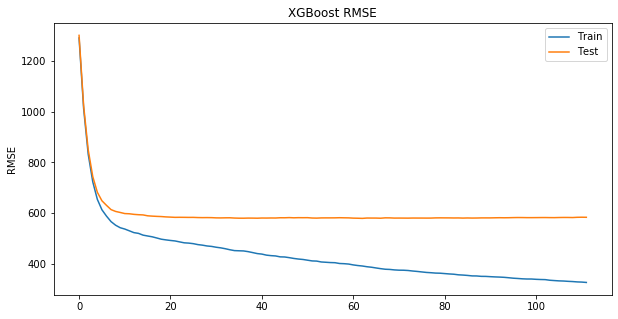

In [106]:
plot_n_estimators(m)

In [107]:
shap.initjs()
explainer = shap.TreeExplainer(m)
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


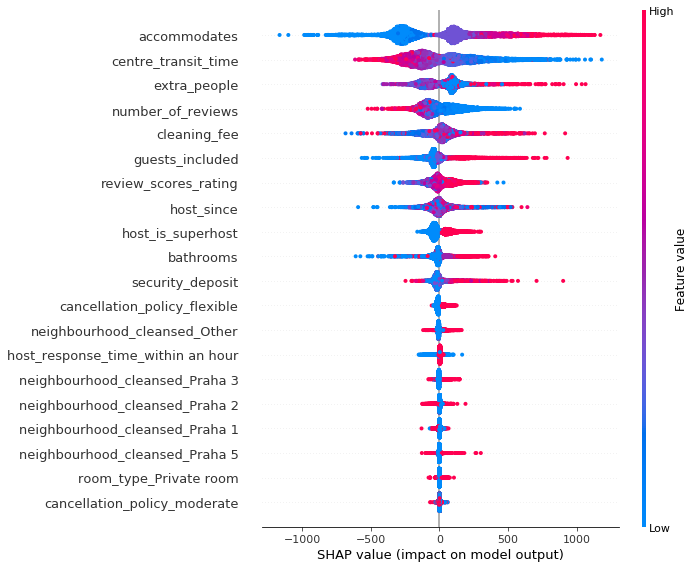

In [108]:
shap.summary_plot(shap_values, X)

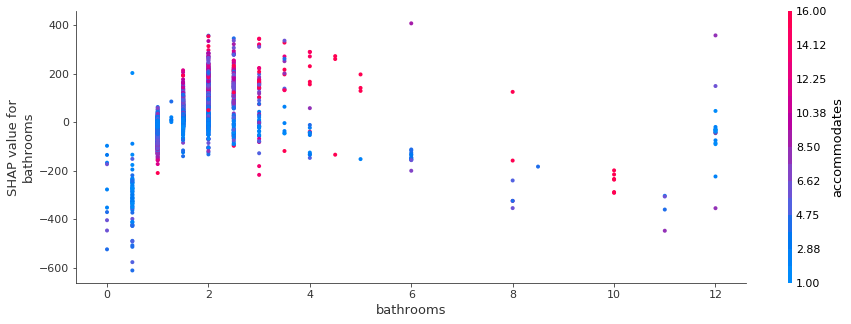

In [118]:
fig, ax = plt.subplots(figsize = (15, 5))
shap.dependence_plot("bathrooms", shap_values, X, ax = ax)

In [ ]:
explainer.shap_interaction_values(X)